In [48]:
ENVIRONMENT = 'blaze'
# ENVIRONMENT = 'colab'
# ENVIRONMENT = 'cpom'
# ENVIRONMENT = 'local'


In [173]:
if ENVIRONMENT == 'blaze':
    !source /usr/local/cuda/CUDA_VISIBILITY.csh
    !source /server/opt/cuda/enable_cuda_11.0
    # !source ~/projects/enable_cuda
    # !source /opt/cuda/enable_cuda_10.0


GPU 0 is in use
GPU 1 is in use
GPU 2 is in use
GPU 4 is free.
Setting environment to use GPU: 3


In [174]:
if ENVIRONMENT == 'blaze':
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    # os.environ['CUDA_HOME'] = '/opt/cuda/cuda-10.0'
    

In [51]:
if ENVIRONMENT == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/sis2/')
    

In [52]:
import tensorflow as tf

import os
import glob
import time
import datetime
import random

import sis_helper as helper
from sis_helper import RGBProfile as rgb

from matplotlib import pyplot as plt
import numpy as np


In [53]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if True]

get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [54]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
with tf.compat.v1.Session() as sess:
    device_name = tf.test.gpu_device_name()
    if device_name != '':
        print('TensorFlow is using GPU:', device_name)
    else:
        print('TensorFlow is not using GPU')

TensorFlow is using GPU: /device:GPU:0


In [57]:
TILESIZE = 256
IMG_WIDTH = 256
IMG_HEIGHT = 256

# TILESIZE = 960
# IMG_WIDTH = 1024
# IMG_HEIGHT = 1024


# The training set consist of n images
# TODO: read automatically
BUFFER_SIZE = 1077
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 50
LAMBDA = 100

OUTPUT_CHANNELS = 3
if ENVIRONMENT == 'blaze':
    PATH_PREFIX = '/cs/student/msc/aisd/2022/cboehm/projects/li1_data/'
elif ENVIRONMENT == 'colab':
    PATH_PREFIX = f'/content/drive/MyDrive/sis2/data/'
elif ENVIRONMENT == 'local':
    PATH_PREFIX = f'/Users/christianboehm/projects/sis2/data/'
elif ENVIRONMENT == 'cpom':
    PATH_PREFIX = f'/home/cb/sis2/data/'
else:
    PATH_PREFIX = f'~/projects/sis2/data'

PATH_TRAIN = os.path.join(PATH_PREFIX, f'tfrecords{TILESIZE}/')
PATH_VAL = os.path.join(PATH_PREFIX, f'tfrecords{TILESIZE}/')
PATH_LOGS = os.path.join(PATH_PREFIX, 'logs/')
PATH_CHKPT = os.path.join(PATH_PREFIX, 'checkpoints/')

BUFFER_SIZE = number_of_files = len(glob.glob(os.path.join(PATH_TRAIN, '*')))


In [58]:
def normalize_tensor(input_image, real_image):
    return tf.nn.l2_normalize(input_image), tf.nn.l2_normalize(real_image)



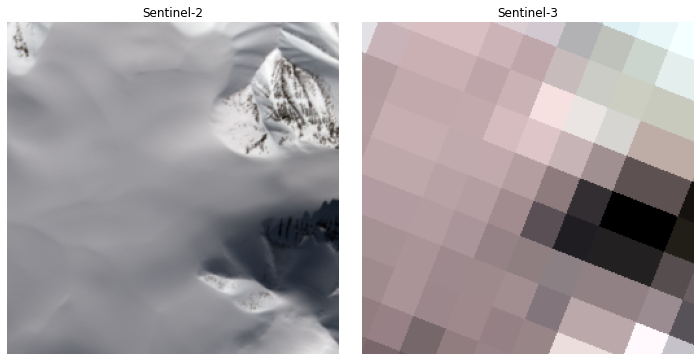

In [64]:
sample_dataset = tf.data.TFRecordDataset(os.path.join(PATH_VAL, random.choice(os.listdir(PATH_VAL))))
for element in sample_dataset:
    helper.plot_tensor_sbs(element, TILESIZE)

    # s2_tensor, s3_tensor = helper.parse_tfrecord(element, TILESIZE)
    # helper.plot_tensor(s2_tensor, rgb.S2)
    # helper.plot_tensor(s3_tensor, rgb.S3)


In [66]:
def resize(image1, image2, height, width):
    image1 = tf.image.resize(image1, [height, width],
                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image2 = tf.image.resize(image2, [height, width],
                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image1, image2

s2_tensor, s3_tensor = resize(s2_tensor, s3_tensor, IMG_HEIGHT, IMG_WIDTH)


In [ ]:
# def resize_one(input_image, height, width):
#   input_image = tf.image.resize(input_image, [height, width],
#                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   return input_image

In [ ]:
# def stretch(input_image, height, width):
#   input_image = tf.image.resize(input_image, [height, width],
#                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   return input_image

# s2_tensor = stretch(s2_tensor, 1024, 1024)
# s3_tensor = stretch(s3_tensor, 1024, 1024)

In [115]:
def random_crop(s2_image, s3_image):
    #TODO: Crop not to 3channels only!
    stacked_image = tf.concat([s2_image, s3_image], axis=2)
    cropped_image = tf.image.random_crop(stacked_image, size=[IMG_HEIGHT, IMG_WIDTH, 24])
    
    return cropped_image[:,:,:3], cropped_image[:,:,3:]
    # return resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)

In [ ]:
# # Normalizing the images to [-1, 1]
# def normalize(input_image, real_image):
#   # TODO: reflect which normalization is needed... divide by 1024????
#   input_image = (input_image / 127.5) - 1
#   real_image = (real_image / 127.5) - 1

#   return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(s2_image, s3_image):
    # Resizing to 286x286
    s2_image, s3_image = resize(s2_image, s3_image, int(IMG_HEIGHT * 1.11), int(IMG_WIDTH * 1.11))
    
    # Random cropping back to 256x256
    s2_image, s3_image = random_crop(s2_image, s3_image)
    
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        s2_image = tf.image.flip_left_right(s2_image)
        s3_image = tf.image.flip_left_right(s3_image)
        
    return s2_image, s3_image


In [47]:
def load_image_train(tfrecord):
    s2_image, s3_image = helper.parse_tfrecord(tfrecord, TILESIZE)
    s2_image, s3_image = resize(s2_image, s3_image, IMG_HEIGHT, IMG_WIDTH)
    s2_image, s3_image = random_jitter(s2_image, s3_image)
    s2_image, s3_image = normalize_tensor(s2_image, s3_image)
    
    return s2_image, s3_image


In [ ]:
def load_image_test(image_file):
    s2_image, s3_image = helper.parse_tfrecord(image_file, TILESIZE)
    s2_image, s3_image = resize(s2_image, s3_image, IMG_HEIGHT, IMG_WIDTH)
    s2_image, s3_image = normalize_tensor(s2_image, s3_image)
    
    return s2_image, s3_image

# def load_image_test(image_file):
#   input_image, real_image = load(image_file)
#   input_images = imageise_input_image(input_image)
#   temp = []
#   for image in input_images:
#     temp.append(resize_one(image, IMG_HEIGHT, IMG_WIDTH))
#   input_image = tf.stack(temp, axis=2)[:,:,:,0]
#   real_image = imageise_real_image(real_image)
#   real_image = resize_one(real_image, IMG_HEIGHT, IMG_WIDTH)
#   real_image = real_image[:,:,0]
#
#   input_image, real_image = normalize(input_image, real_image)
#
#   return input_image, real_image

In [ ]:
train_file_list = [os.path.join(PATH_TRAIN, file) for file in os.listdir(PATH_TRAIN) if file.endswith('.tfrecord')]
train_dataset = tf.data.TFRecordDataset(train_file_list)

# train_dataset = tf.data.Dataset.list_files(str(f'{PATH_TRAIN}/*.tfrecords'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [159]:
test_file_list = [os.path.join(PATH_VAL, file) for file in os.listdir(PATH_VAL) if file.endswith('.tfrecord')]

try:
    test_dataset = tf.data.TFRecordDataset(test_file_list)
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.TFRecordDataset(train_file_list)
test_dataset = test_dataset.map(load_image_test)
#TODO: check if shuffling is helpful (added for validation)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [171]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters, size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [172]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(s3_tensor, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [117]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
        
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result


In [118]:
up_model = upsample(21, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 21)


In [121]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 21])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh')  # (batch_size, 256, 256, 3)
        
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    

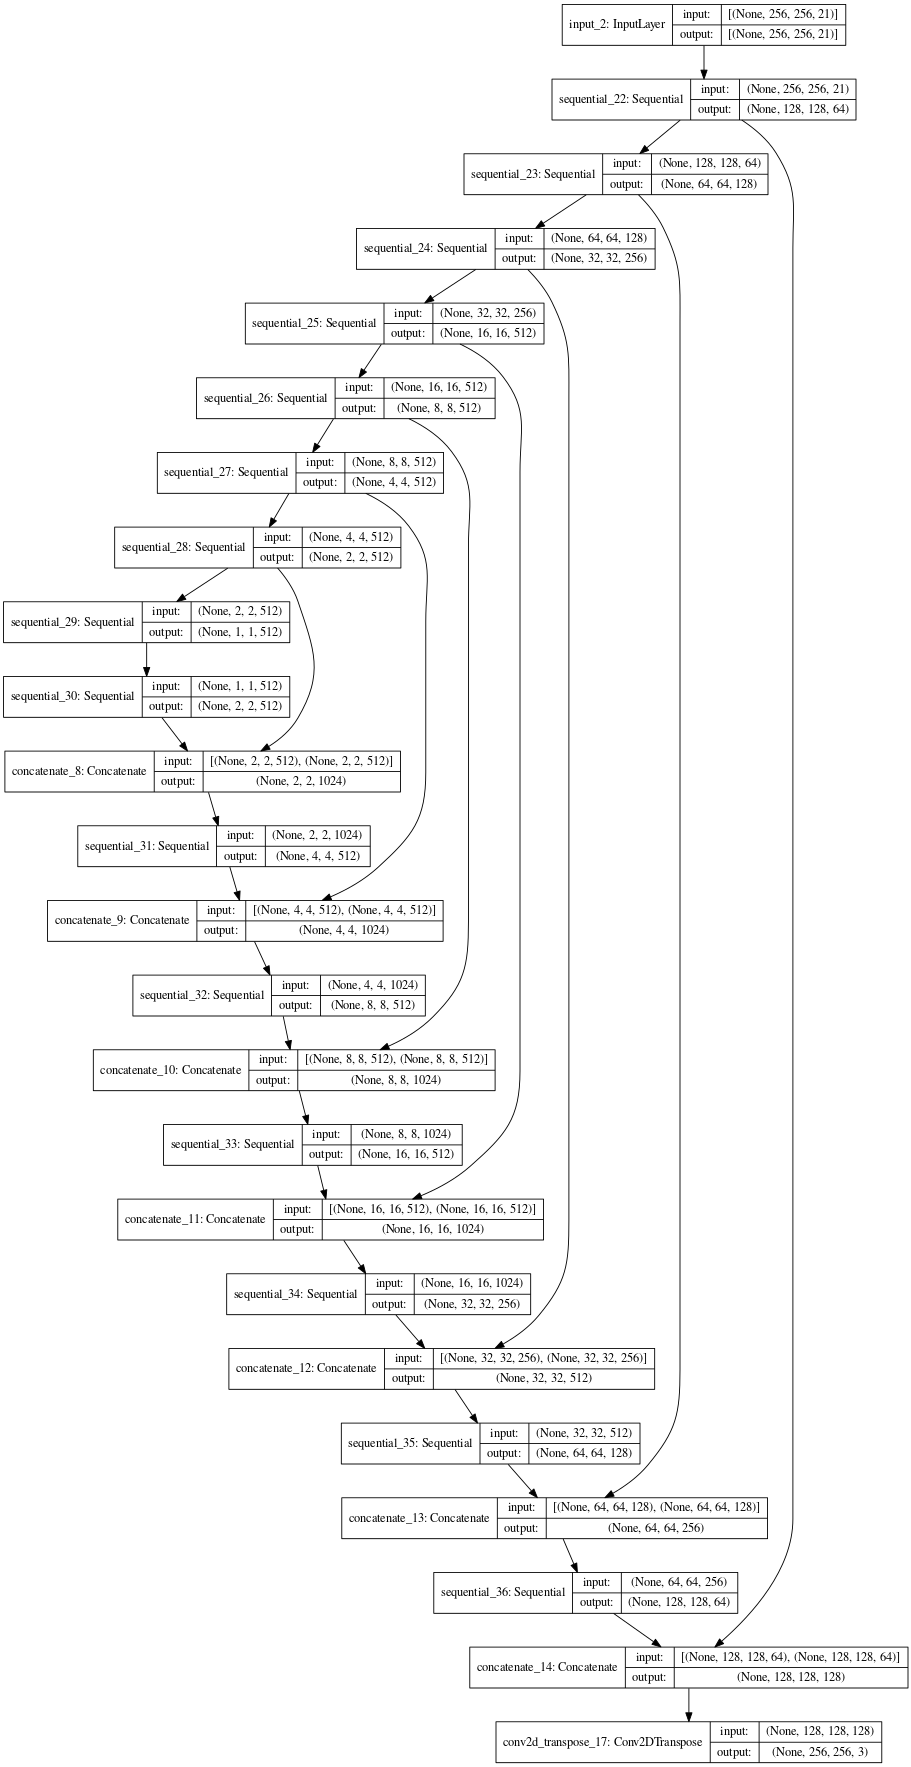

In [122]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

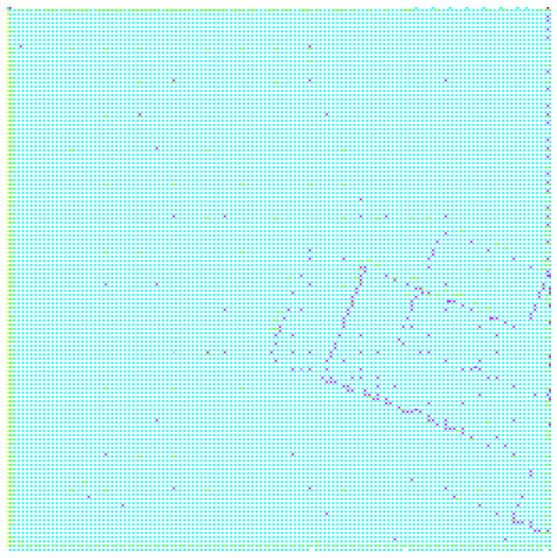

In [170]:
gen_output = generator(s3_tensor[tf.newaxis, ...], training=False)
helper.plot_tensor(gen_output[0], rgb.S2)


In [124]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    rmse_loss = tf.reduce_mean((target - gen_output) ** 2) ** 1/2

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss, rmse_loss
    

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 21], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
    

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [ ]:
disc_out = discriminator([s3_tensor[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_prefix = os.path.join(PATH_CHKPT, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [157]:
def generate_images(model, example_input, example_target, num_images=5):
    #TODO: training True or False!?
    prediction = model(example_input, training=False)

    for i in range(num_images):
        display_list = [example_input[i], example_target[i], prediction[i]]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))

        helper.plot_tensor(display_list[0], rgb.S3, ax=ax1)
        ax1.set_title('Input Image')
        ax1.axis('off')

        helper.plot_tensor(display_list[1], rgb.S2, ax=ax2)
        ax2.set_title('Ground Truth')
        ax2.axis('off')

        helper.plot_tensor(display_list[2], rgb.S2, ax=ax3)
        ax3.set_title('Predicted Image')
        ax3.axis('off')

        plt.tight_layout()
        plt.show()


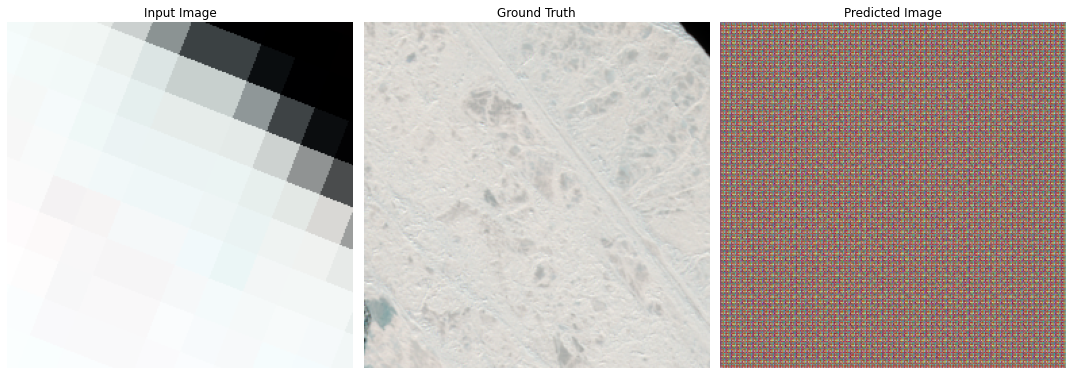

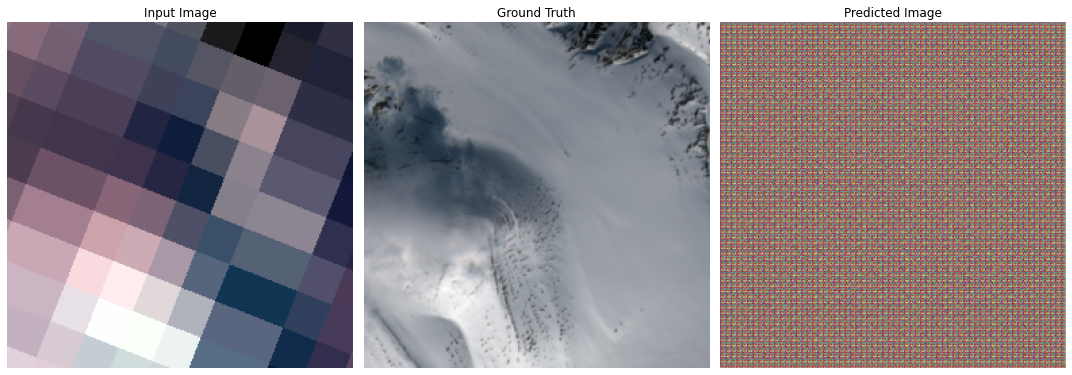

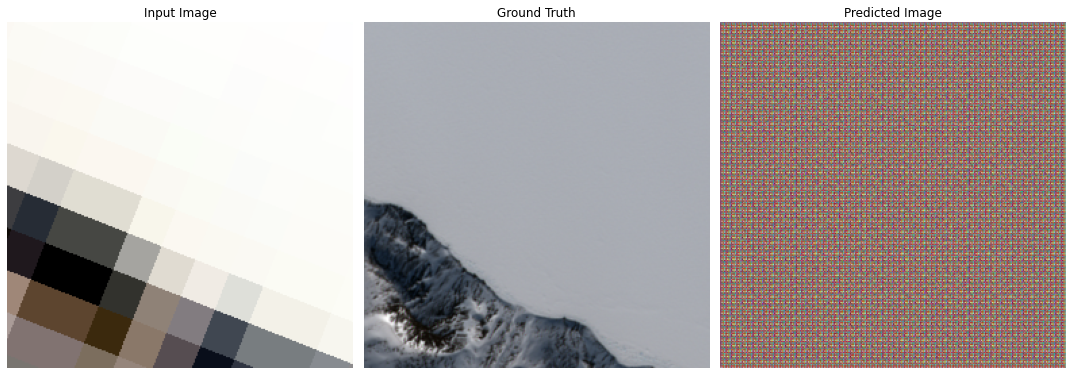

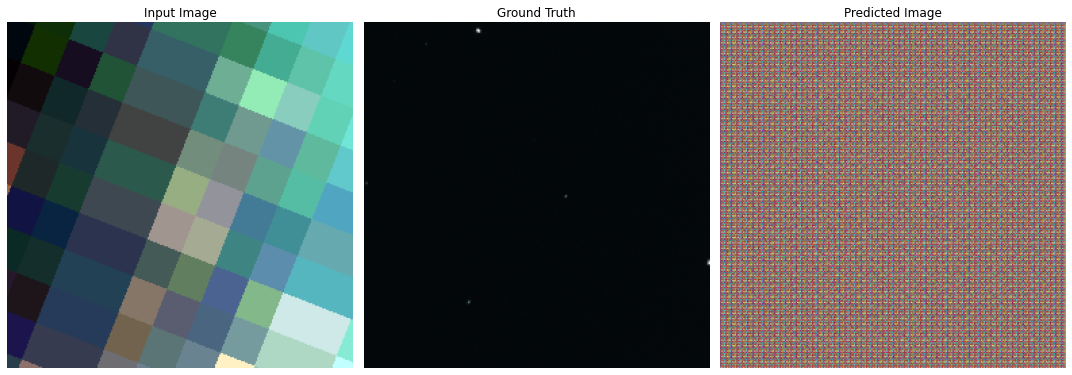

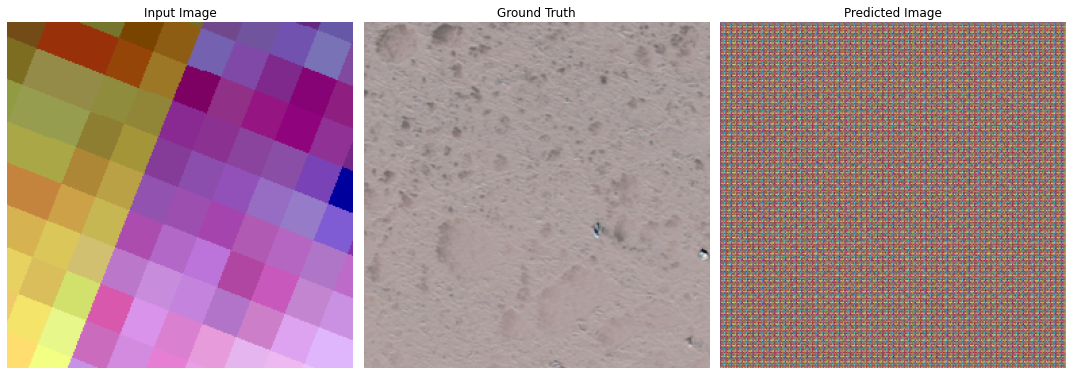

In [162]:
for example_target, example_input in test_dataset.take(1):
    generate_images(generator, example_input, example_target)
    

In [ ]:
summary_writer = tf.summary.create_file_writer(
    PATH_LOGS + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    

In [126]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_rmse_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('gen_rmse_loss', gen_rmse_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [ ]:
def fit(train_ds, test_ds, steps):
    # example_target, example_input = next(iter(test_ds.take(1)))
    start = time.time()
    
    for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            # display.clear_output(wait=True)
            
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
                start = time.time()

            for example_target, example_input in test_dataset.take(5):
                generate_images(generator, example_input, example_target)

            print(f"Step: {step // 1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step + 1) % 10 == 0:
        print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
fit(train_dataset, test_dataset, steps=5000)

In [ ]:
!tensorboard dev upload --logdir {PATH_LOGS}
